<a href="https://colab.research.google.com/github/isaacfinberg/Novozymes-Enzyme-Stability-Prediction/blob/develop/Thermomut_10_26_Louis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install pandas
!pip install sentence_transformers
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  
!mkdir -p ~/.kaggle                                          
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log 
!chmod 600 ~/.kaggle/kaggle.json                            
!kaggle config set -n competition -v novozymes-enzyme-stability-prediction   
!kaggle competitions download -c novozymes-enzyme-stability-prediction         
!unzip -o *.zip >> log

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
- competition is now set to: novozymes-enzyme-stability-prediction
novozymes-enzyme-stability-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
SEED = 42
import os
import random as rn
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)

In [4]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/isaacfinberg/Novozymes-Enzyme-Stability-Prediction/main/MutationsDeltaTM.csv')
df

,Unnamed: 0,mutated_sequence,pdb_id,wt_sequence,mutations,delta_tm
0,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,W138Y,-6.3
1,1,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-6.2
2,2,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-6.6
3,3,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,E128A,0.6
4,4,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,V131A,1.0
...,...,...,...,...,...,...
4377,993,MQTLLVSSLVVSLAAALPHYIRSNGIEASLLTDPKDVSGRTVDYII...,1CF3,MQTLLVSSLVVSLAAALPHYIRSNGIEASLLTDPKDVSGRTVDYII...,V442G,2.0
4378,994,MQTLLVSSLVVSLAAALPHYIRSNGIEASLLTDPKDVSGRTVDYII...,1CF3,MQTLLVSSLVVSLAAALPHYIRSNGIEASLLTDPKDVSGRTVDYII...,S444N,3.0
4379,995,MQTLLVSSLVVSLAAALPHYIRSNGIEASLLTDPKDVSGRTVDYII...,1CF3,MQTLLVSSLVVSLAAALPHYIRSNGIEASLLTDPKDVSGRTVDYII...,D473N,4.0
4380,996,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,W138Y,-6.3


In [5]:
from sentence_transformers import SentenceTransformer as SBERT
sbert = SBERT('all-mpnet-base-v2')

In [6]:
import numpy as np

embedding_dim = sbert.get_sentence_embedding_dimension()

def get_sbert_embedding(sequence):
  encoded = np.zeros(4*embedding_dim)
  for i in range(0, 4):
    seq_slice = sequence[i*100:i*100+100]
    encoded[i*embedding_dim:i*embedding_dim+embedding_dim] = sbert.encode(seq_slice)
  return encoded

test = get_sbert_embedding(df.wt_sequence.values[0])
test.shape

(3072,)

In [7]:
wt_sequence_embeddings = np.asarray([get_sbert_embedding(v) for v in df.wt_sequence.values])
mutated_sequence_embeddings = np.asarray([get_sbert_embedding(v) for v in df.mutated_sequence.values])

In [8]:
from sklearn.model_selection import train_test_split

X = np.hstack([wt_sequence_embeddings, mutated_sequence_embeddings])
y = df.delta_tm.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33,random_state=SEED)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 1024)              6292480   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 6,297,601
Trainable params: 6,295,553
Non-trainable params: 2,048
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 1s 238ms/step - loss: 55.0406 - mse: 55.0406 - val_loss:

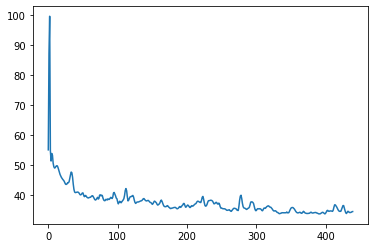

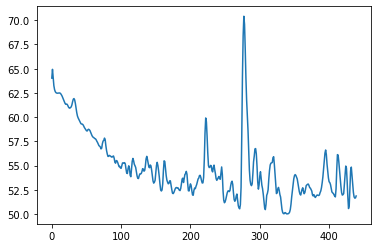

In [9]:
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

GlorotInit = keras.initializers.GlorotNormal(seed=SEED)

m = keras.models.Sequential([
    Flatten(input_shape=[X.shape[1]]),
    Dense(1024, activation="relu", kernel_initializer=GlorotInit),
    #Dropout(0.05),
    BatchNormalization(),
    Dense(1, kernel_initializer=GlorotInit)
])

m.summary()

m.compile(loss="mse", optimizer="adam", metrics=['mse'])

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=100,
    min_delta=0.0001,
    restore_best_weights=True,
)

hist = m.fit(X_train, y_train, 
             batch_size=2048, 
             epochs=1000, 
             validation_split=0.3, 
             callbacks=[callback], 
             #verbose=False
)

plt.plot(hist.history['mse'])
plt.show()

plt.plot(hist.history['val_mse'])
plt.show()

In [10]:
from scipy.stats import spearmanr

y_pred = m.predict(X_test)
mse = mean_squared_error(y_pred, y_test)
corr = spearmanr(y_pred, y_test)

print('MSE: %f' % mse)
print('Corr: %f' % corr[0])

46/46 [==============================] - 0s 2ms/step
MSE: 38.364693
Corr: 0.394293


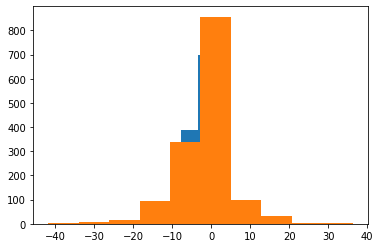

In [11]:
plt.hist(y_pred)
plt.hist(y_test)
plt.show()

In [12]:
df_test = pd.read_csv('test.csv', low_memory=False); df_test

wt = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
encoded_wt = get_sbert_embedding(wt)

test_wt_sequence_embeddings = np.asarray([encoded_wt for x in range(0, len(df_test.protein_sequence.values))])
test_mutated_sequence_embeddings = np.asarray([ get_sbert_embedding(v) for v in df_test.protein_sequence.values])

test_embeddings = np.hstack([test_wt_sequence_embeddings,test_mutated_sequence_embeddings])

76/76 [==============================] - 0s 2ms/step
-3.5064673


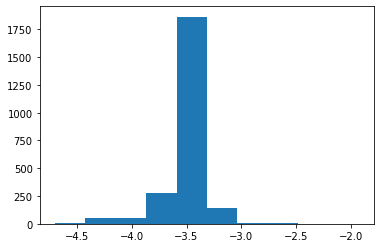

In [13]:
preds = m.predict(test_embeddings)
preds
# -3.6368814

print(np.mean(preds))

plt.hist(preds)
plt.show()

In [15]:
pY = pd.DataFrame(preds, index=range(31390,len(preds)+31390), columns=['tm'])

ToCSV = lambda df_tmp, fname: df_tmp.round(5).to_csv(f'{fname}.csv', index_label='seq_id')
ToCSV(pY, '/content/gdrive/MyDrive/Kaggle/Novozymes_Submission')